In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import matplotlib.pyplot as plt
import yfinance as yf
import matplotlib.dates as mdates


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense

from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Data Preparation

In [16]:
# Download stock data
df = yf.download("AAPL", start="2015-02-26", end="2024-04-26")
company = 'Apple'
df.reset_index(inplace=True)

[*********************100%%**********************]  1 of 1 completed


In [15]:
# Load the timestamp data
timestamp_df = pd.read_csv('daily_mentions_apple.csv', parse_dates=['timestamp'], dayfirst=True)

# Rename columns for clarity
timestamp_df.rename(columns={'timestamp': 'Date', 'Apple': 'Mentions'}, inplace=True)

# Merge with stock price data
merged_df = pd.merge(df, timestamp_df, on='Date', how='left')

# Check if the Mentions column is added correctly
print(merged_df.head())

        Date       Open       High        Low      Close  Adj Close  \
0 2015-02-26  32.197498  32.717499  31.652500  32.605000  29.224289   
1 2015-02-27  32.500000  32.642502  32.060001  32.115002  28.785097   
2 2015-03-02  32.312500  32.570000  32.075001  32.272499  28.926262   
3 2015-03-03  32.240002  32.380001  32.022499  32.340000  28.986767   
4 2015-03-04  32.275002  32.389999  32.080002  32.134998  28.803024   

      Volume  Mentions  
0  365150000    3336.0  
1  248059200   19498.0  
2  192386800   12426.0  
3  151265200   37832.0  
4  126665200   25585.0  


<ipython-input-15-64bd48b171e9>:2: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  timestamp_df = pd.read_csv('daily_mentions_apple.csv', parse_dates=['timestamp'], dayfirst=True)


In [17]:
# Fill NaN values in Mentions with 0 (assuming no mentions on those days)
merged_df['Mentions'].fillna(0, inplace=True)

# Select stock price records for the last five years, starting from 2019
data_5years = merged_df[merged_df["Date"].dt.year >= 2015]

# Check filtered data shape
data_5years.shape

(2307, 8)

# Split Data

In [18]:
# Define selected features and target attribute
features = ["Open", "High", "Low", "Close", "Adj Close", "Volume", "Mentions"]
target = "Close"

# Define start and end time for each period
train_end_date = pd.to_datetime("2023-06-30")
validate_start_date = pd.to_datetime("2023-07-01")
validate_end_date = pd.to_datetime("2023-12-31")
test_start_date = pd.to_datetime("2024-01-01")
test_end_date = pd.to_datetime("2024-02-29")

# Split dataset into training, validation, and testing
data_train = data_5years[data_5years["Date"] <= train_end_date][features]
data_train_dates = data_5years[data_5years["Date"] <= train_end_date]["Date"]
data_validate = data_5years[(data_5years["Date"] >= validate_start_date) & (data_5years["Date"] <= validate_end_date)][features]
data_validate_dates = data_5years[(data_5years["Date"] >= validate_start_date) & (data_5years["Date"] <= validate_end_date)]["Date"]
data_test = data_5years[(data_5years["Date"] >= test_start_date) & (data_5years["Date"] <= test_end_date)][features]
data_test_dates = data_5years[(data_5years["Date"] >= test_start_date) & (data_5years["Date"] <= test_end_date)]["Date"]

In [19]:
# Initialize scaler with range [0,1]
sc = MinMaxScaler(feature_range=(0,1))

# Fit and transform scaler to training set
data_train_scaled = sc.fit_transform(data_train)

# Transform validating and testing datasets
data_validate_scaled = sc.transform(data_validate)
data_test_scaled = sc.transform(data_test)

# Combine dates with each corresponding dataset
data_train_scaled_final = pd.DataFrame(data_train_scaled, columns=features, index=None)
data_train_scaled_final["Date"] = data_train_dates.values

data_validate_scaled_final = pd.DataFrame(data_validate_scaled, columns=features, index=None)
data_validate_scaled_final["Date"] = data_validate_dates.values

data_test_scaled_final = pd.DataFrame(data_test_scaled, columns=features, index=None)
data_test_scaled_final["Date"] = data_test_dates.values

# Check loaded datasets shape
data_train_df = data_train_scaled_final
data_validate_df = data_validate_scaled_final
data_test_df = data_test_scaled_final
print(f"Training Dataset Shape: {data_train_df.shape}")
print(f"Validation Dataset Shape: {data_validate_df.shape}")
print(f"Testing Dataset Shape: {data_test_df.shape}")

Training Dataset Shape: (2101, 8)
Validation Dataset Shape: (126, 8)
Testing Dataset Shape: (41, 8)


In [20]:
# Convert Date column to a valid Datetime format
data_train_df["Date"] = pd.to_datetime(data_train_df["Date"])
data_validate_df["Date"] = pd.to_datetime(data_validate_df["Date"])
data_test_df["Date"] = pd.to_datetime(data_test_df["Date"])

# Extract dates from each dataset
data_train_dates = data_train_df["Date"]
data_validate_dates = data_validate_df["Date"]
data_test_dates = data_test_df["Date"]

# Extract features
features = ["Open", "High", "Low", "Close", "Adj Close", "Volume", "Mentions"]
data_train_scaled = data_train_df[features].values
data_validate_scaled = data_validate_df[features].values
data_test_scaled = data_test_df[features].values

In [21]:
#Define a method to construct the input data X and Y
def construct_lstm_data(data, sequence_size, target_attr_idx):

    # Initialize constructed data variables
    data_X = []
    data_y = []

    # Iterate over the dataset
    for i in range(sequence_size, len(data)):
        data_X.append(data[i-sequence_size:i,0:data.shape[1]])
        data_y.append(data[i,target_attr_idx])

    # Return constructed variables
    return np.array(data_X), np.array(data_y)

#LSTM model

In [22]:
# Define the sequence size
sequence_size = 60

# Construct training data
X_train, y_train = construct_lstm_data(data_train_scaled, sequence_size, 0)

# Combine scaled datasets all together
data_all_scaled = np.concatenate([data_train_scaled, data_validate_scaled, data_test_scaled], axis=0)

# Calculate data size
train_size = len(data_train_scaled)
validate_size = len(data_validate_scaled)
test_size = len(data_test_scaled)

# Construct validation dataset
X_validate, y_validate = construct_lstm_data(data_all_scaled[train_size-sequence_size:train_size+validate_size,:], sequence_size, 0)

# Construct testing dataset
X_test, y_test = construct_lstm_data(data_all_scaled[-(test_size+sequence_size):,:], sequence_size, 0)

# Initializing the model
regressor = Sequential()

# Add input layer
regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# Add first LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

# Add second LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

# Add third LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

# Add forth LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100))
regressor.add(Dropout(rate = 0.2))

# Add last dense layer/output layer
regressor.add(Dense(units = 1))

# Compiling the model
regressor.compile(optimizer = "adam", loss="mean_squared_error")

In [23]:
# Create a checkpoint to monitor the validation loss and save the model with the best performance.
model_location = "..//models//"
model_name = "Apple_stock_price_lstm.model.keras"
best_model_checkpoint_callback = ModelCheckpoint(
    model_location + model_name,
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=0)

# Training the model
history = regressor.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_validate, y_validate),
    epochs=50,
    batch_size = 64,
    callbacks = [best_model_checkpoint_callback])

# Prepare model location and name
model_location = "..//models//"
model_name = "Apple_stock_price_lstm.model.keras"

# Load the best performing model
best_model = load_model(model_location + model_name)

# Predict stock price for all data splits
y_train_predict = best_model.predict(X_train)
y_validate_predict = best_model.predict(X_validate)
y_test_predict = best_model.predict(X_test)

# Restore actual distribution for predicted prices
y_train_inv = sc.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((len(y_train), 6))), axis=1))[:, 0]
y_validate_inv = sc.inverse_transform(np.concatenate((y_validate.reshape(-1, 1), np.zeros((len(y_validate), 6))), axis=1))[:, 0]
y_test_inv = sc.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), 6))), axis=1))[:, 0]

y_train_predict_inv = sc.inverse_transform(np.concatenate((y_train_predict, np.zeros((len(y_train_predict), 6))), axis=1))[:, 0]
y_validate_predict_inv = sc.inverse_transform(np.concatenate((y_validate_predict, np.zeros((len(y_validate_predict), 6))), axis=1))[:, 0]
y_test_predict_inv = sc.inverse_transform(np.concatenate((y_test_predict, np.zeros((len(y_test_predict), 6))), axis=1))[:, 0]

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - loss: 0.0429 - val_loss: 0.0025
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0028 - val_loss: 0.0042
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022 - val_loss: 0.0069
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0022 - val_loss: 0.0057
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0018 - val_loss: 0.0067
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0

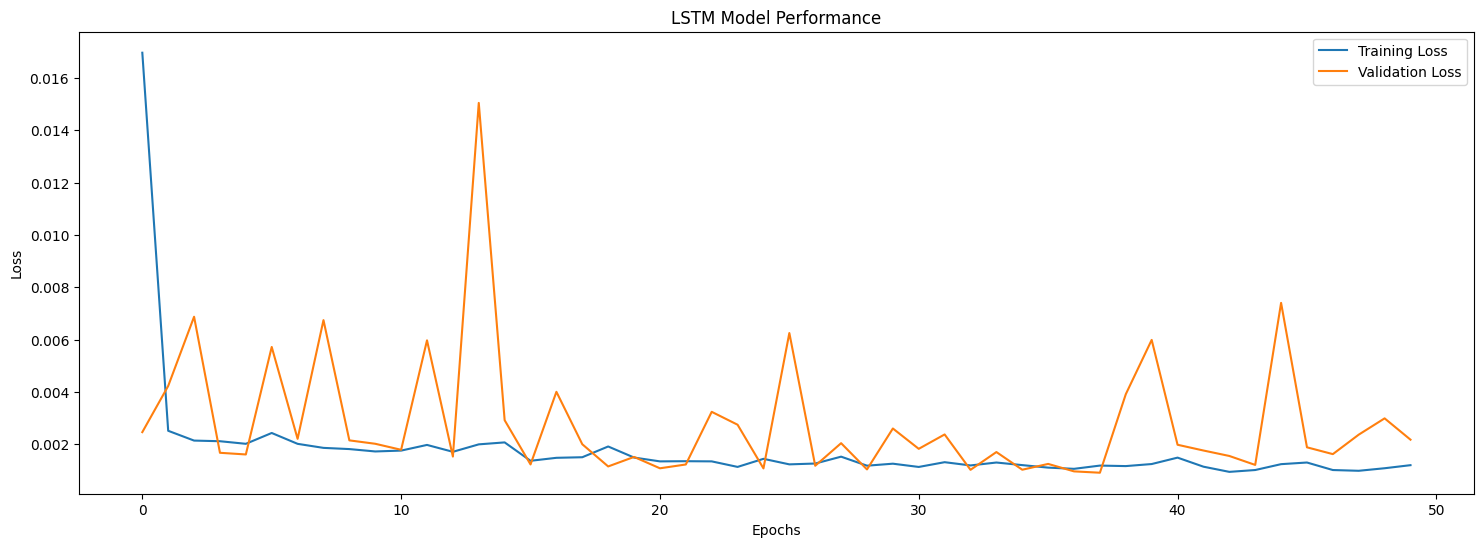

In [24]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("LSTM Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

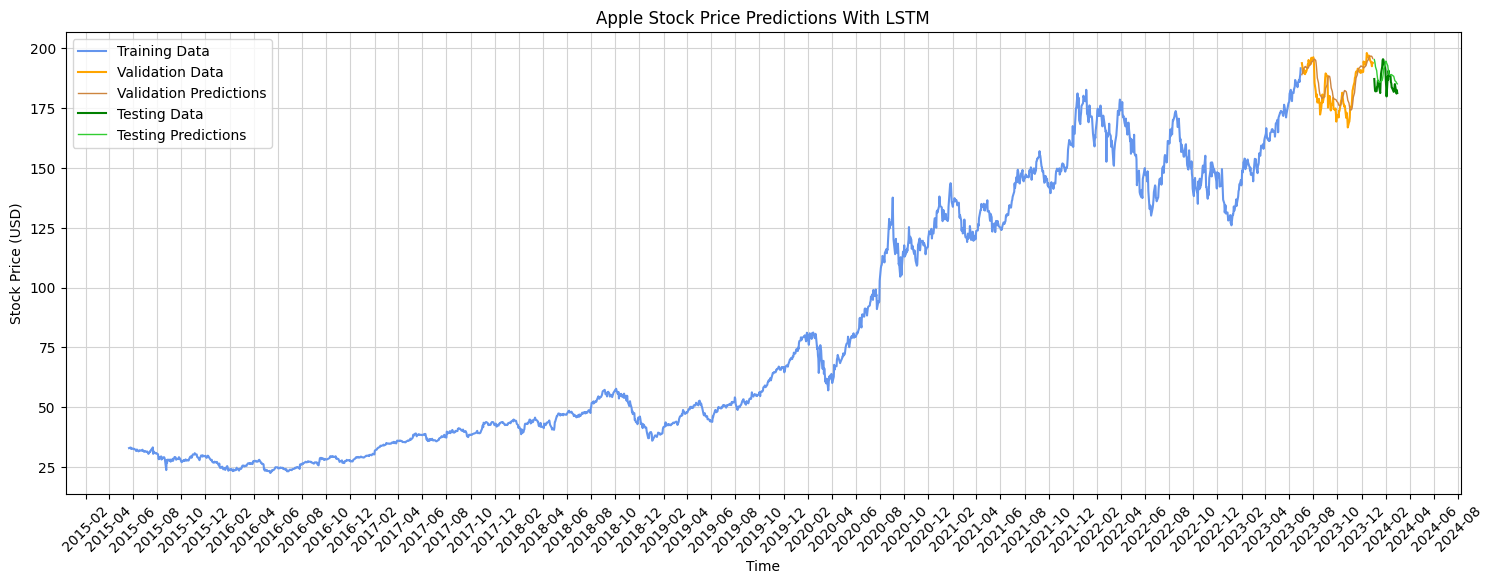

In [25]:
# Define chart colors
train_actual_color = "cornflowerblue"
validate_actual_color = "orange"
test_actual_color = "green"
train_predicted_color = "lightblue"
validate_predicted_color = "peru"
test_predicted_color = "limegreen"

# Plot actual and predicted price
plt.figure(figsize=(18, 6))
plt.plot(data_train_dates[sequence_size:], y_train_inv, label="Training Data", color=train_actual_color)


plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=1, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=1, color=test_predicted_color)

plt.title("Apple Stock Price Predictions With LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")
plt.show()

In [26]:
# Create individual dataframes for training, validation, and test sets
train_df = pd.DataFrame({
    'Date': data_train_dates[sequence_size:],  # Adjusting the dates to match the training data length
    'Actual_Train_Price': y_train_inv,
    'Predicted_Train_Price': y_train_predict_inv
})

validate_df = pd.DataFrame({
    'Date': data_validate_dates,
    'Actual_Validate_Price': y_validate_inv,
    'Predicted_Validate_Price': y_validate_predict_inv
})

test_df = pd.DataFrame({
    'Date': data_test_dates,
    'Actual_Test_Price': y_test_inv,
    'Predicted_Test_Price': y_test_predict_inv
})



# Print the first few rows of the dataframe
print(train_df.head())


         Date  Actual_Train_Price  Predicted_Train_Price
60 2015-05-22           32.900002              31.795763
61 2015-05-26           33.150002              31.887290
62 2015-05-27           32.584999              31.943006
63 2015-05-28           32.965000              31.963187
64 2015-05-29           32.807499              31.978899


In [27]:
print(test_df.tail())

         Date  Actual_Test_Price  Predicted_Test_Price
36 2024-02-23         185.009995            186.433273
37 2024-02-26         182.240005            185.962111
38 2024-02-27         181.100006            185.603703
39 2024-02-28         182.509995            185.332163
40 2024-02-29         181.270004            185.122903


# GRU Model

In [28]:
from tensorflow.keras.layers import GRU

# Define the GRU model
gru_regressor = Sequential()

# Add input layer
gru_regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# Add first GRU layer and dropout regularization layer
gru_regressor.add(GRU(units=100, return_sequences=True))
gru_regressor.add(Dropout(rate=0.2))

# Add second GRU layer and dropout regularization layer
gru_regressor.add(GRU(units=100, return_sequences=True))
gru_regressor.add(Dropout(rate=0.2))

# Add third GRU layer and dropout regularization layer
gru_regressor.add(GRU(units=100, return_sequences=True))
gru_regressor.add(Dropout(rate=0.2))

# Add fourth GRU layer and dropout regularization layer
gru_regressor.add(GRU(units=100))
gru_regressor.add(Dropout(rate=0.2))

# Add last dense layer/output layer
gru_regressor.add(Dense(units=1))

# Compiling the model
gru_regressor.compile(optimizer="adam", loss="mean_squared_error")

# Create a checkpoint to monitor the validation loss and save the model with the best performance.
gru_model_location = "..//models//"
gru_model_name = "Apple_stock_price_gru.model.keras"
gru_best_model_checkpoint_callback = ModelCheckpoint(
    gru_model_location + gru_model_name,
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=0)

# Training the GRU model
gru_history = gru_regressor.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_validate, y_validate),
    epochs=50,
    batch_size=64,
    callbacks=[gru_best_model_checkpoint_callback])


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0400 - val_loss: 0.0044
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0020 - val_loss: 8.9724e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019 - val_loss: 0.0053
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0018 - val_loss: 7.2385e-04
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0013 - val_loss: 6.3582e-04
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0017 - val_loss: 6.1511e-04
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014 - val_loss: 7.0093e-04
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1

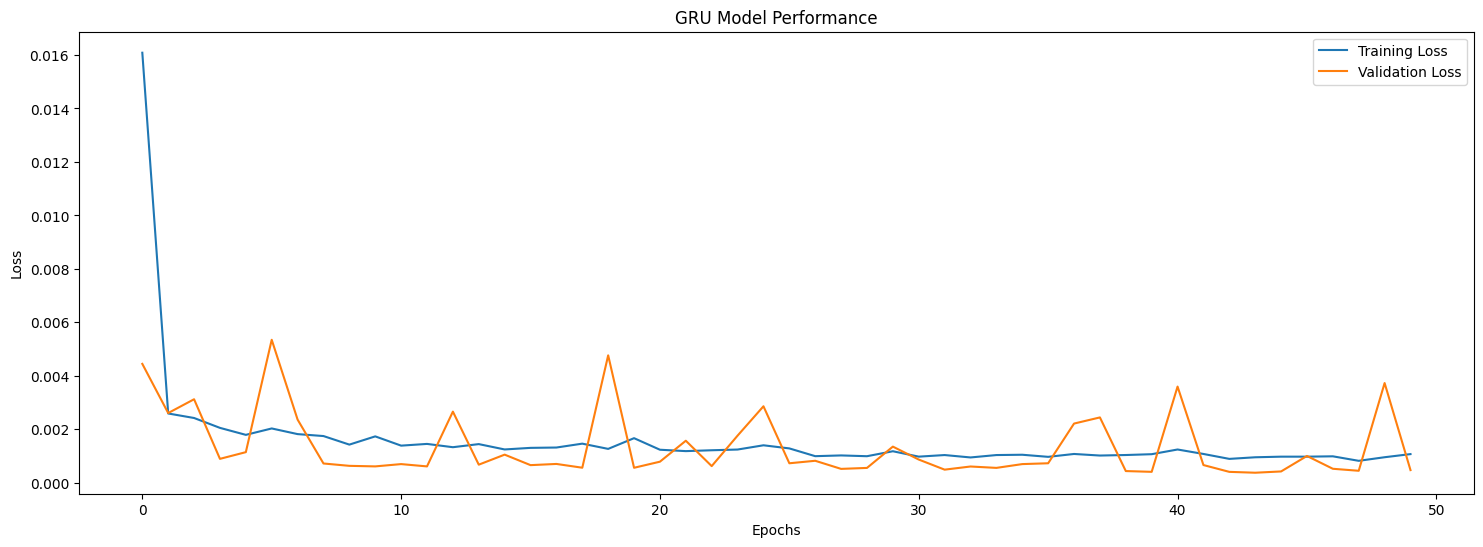

In [29]:
# Visualizing GRU model performance during training
plt.figure(figsize=(18, 6))

plt.plot(gru_history.history["loss"], label="Training Loss")
plt.plot(gru_history.history["val_loss"], label="Validation Loss")

plt.title("GRU Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [30]:
# Load the best performing GRU model
best_gru_model = load_model(gru_model_location + gru_model_name)

# Predict stock price for all data splits with GRU
y_train_gru_predict = best_gru_model.predict(X_train)
y_validate_gru_predict = best_gru_model.predict(X_validate)
y_test_gru_predict = best_gru_model.predict(X_test)

# Restore actual distribution for predicted prices with GRU
y_train_gru_predict_inv = sc.inverse_transform(np.concatenate((y_train_gru_predict, np.zeros((len(y_train_gru_predict), 6))), axis=1))[:, 0]
y_validate_gru_predict_inv = sc.inverse_transform(np.concatenate((y_validate_gru_predict, np.zeros((len(y_validate_gru_predict), 6))), axis=1))[:, 0]
y_test_gru_predict_inv = sc.inverse_transform(np.concatenate((y_test_gru_predict, np.zeros((len(y_test_gru_predict), 6))), axis=1))[:, 0]


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


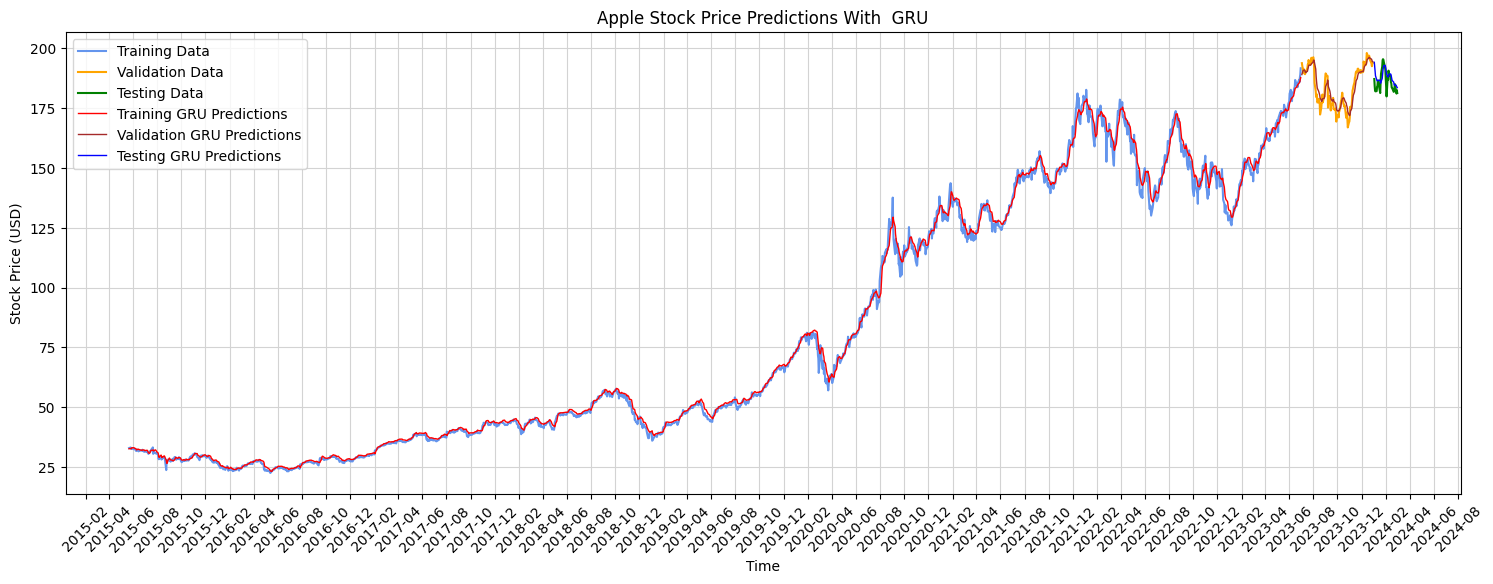

In [31]:
# Define chart colors for GRU
train_gru_predicted_color = "red"
validate_gru_predicted_color = "brown"
test_gru_predicted_color = "blue"

# Plot actual and GRU predicted prices
plt.figure(figsize=(18, 6))

# Plot actual prices
plt.plot(data_train_dates[sequence_size:], y_train_inv, label="Training Data", color=train_actual_color)
plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color)


# Plot GRU predicted prices
plt.plot(data_train_dates[sequence_size:], y_train_gru_predict_inv, label="Training GRU Predictions", linewidth=1, color=train_gru_predicted_color)
plt.plot(data_validate_dates, y_validate_gru_predict_inv, label="Validation GRU Predictions", linewidth=1, color=validate_gru_predicted_color)
plt.plot(data_test_dates, y_test_gru_predict_inv, label="Testing GRU Predictions", linewidth=1, color=test_gru_predicted_color)

# Customize plot
plt.title("Apple Stock Price Predictions With  GRU")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")

# Show plot
plt.show()


In [32]:
# Create individual dataframes for training, validation, and test sets with GRU predictions
train_gru_df = pd.DataFrame({
    'Date': data_train_dates[sequence_size:],
    'Actual_Train_Price': y_train_inv,
    'GRU_Train_Price': y_train_gru_predict_inv
})

validate_gru_df = pd.DataFrame({
    'Date': data_validate_dates,
    'Actual_Validate_Price': y_validate_inv,
    'GRU_Validate_Price': y_validate_gru_predict_inv
})

test_gru_df = pd.DataFrame({
    'Date': data_test_dates,
    'Actual_Test_Price': y_test_inv,
    'GRU_Test_Price': y_test_gru_predict_inv
})
#Print GRU train and test data
print(train_gru_df.head())
print(test_gru_df.tail())

         Date  Actual_Train_Price  GRU_Train_Price
60 2015-05-22           32.900002        32.627489
61 2015-05-26           33.150002        32.763843
62 2015-05-27           32.584999        32.619313
63 2015-05-28           32.965000        32.722928
64 2015-05-29           32.807499        33.042753
         Date  Actual_Test_Price  GRU_Test_Price
36 2024-02-23         185.009995      184.622496
37 2024-02-26         182.240005      184.595489
38 2024-02-27         181.100006      184.156857
39 2024-02-28         182.509995      183.829580
40 2024-02-29         181.270004      183.550046


# Ensemble Model

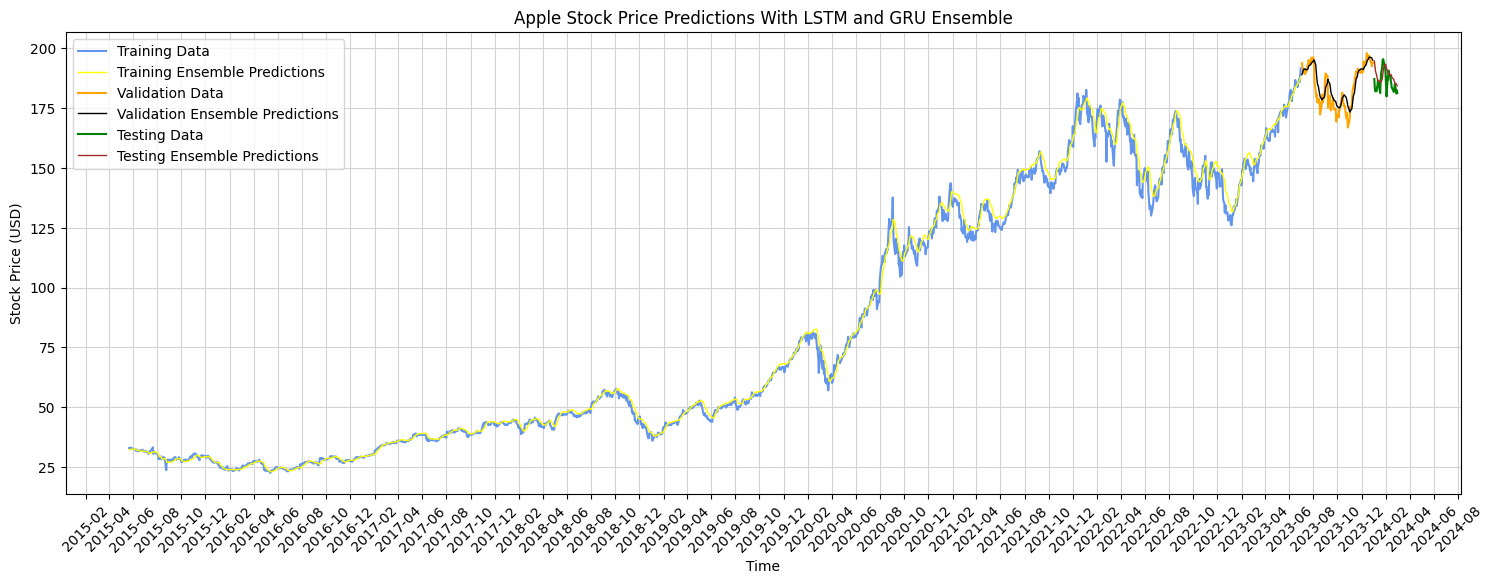

In [39]:
# Average the predictions from LSTM and GRU models
y_train_ensemble_predict_inv = (y_train_predict_inv + y_train_gru_predict_inv) / 2
y_validate_ensemble_predict_inv = (y_validate_predict_inv + y_validate_gru_predict_inv) / 2
y_test_ensemble_predict_inv = (y_test_predict_inv + y_test_gru_predict_inv) / 2

# Plot actual and ensemble predicted price
plt.figure(figsize=(18, 6))
plt.plot(data_train_dates[sequence_size:], y_train_inv, label="Training Data", color=train_actual_color)
plt.plot(data_train_dates[sequence_size:], y_train_ensemble_predict_inv, label="Training Ensemble Predictions", linewidth=1, color="yellow")

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(data_validate_dates, y_validate_ensemble_predict_inv, label="Validation Ensemble Predictions", linewidth=1, color="black")

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color)
plt.plot(data_test_dates, y_test_ensemble_predict_inv, label="Testing Ensemble Predictions", linewidth=1, color="brown")

plt.title("Apple Stock Price Predictions With LSTM and GRU Ensemble")
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")
plt.show()

In [40]:
# Create individual dataframes for training, validation, and test sets
train_df = pd.DataFrame({
    'Date': data_train_dates[sequence_size:],
    'Actual_Train_Price': y_train_inv,
    'LSTM_Train_Price': y_train_predict_inv,
    'GRU_Train_Price': y_train_gru_predict_inv,
    'Ensemble_Train_Price': y_train_ensemble_predict_inv
})

validate_df = pd.DataFrame({
    'Date': data_validate_dates,
    'Actual_Validate_Price': y_validate_inv,
    'LSTM_Validate_Price': y_validate_predict_inv,
    'GRU_Validate_Price': y_validate_gru_predict_inv,
    'Ensemble_Validate_Price': y_validate_ensemble_predict_inv
})

test_df = pd.DataFrame({
    'Date': data_test_dates,
    'Actual_Test_Price': y_test_inv,
    'LSTM_Test_Price': y_test_predict_inv,
    'GRU_Test_Price': y_test_gru_predict_inv,
    'Ensemble_Test_Price': y_test_ensemble_predict_inv
})

# Concatenate the dataframes into a single dataframe
all_data_df = pd.concat([train_df, validate_df, test_df], ignore_index=True)

# Print the first few rows and last few rows of the dataframe
print(train_df.head())
print(test_df.tail())


         Date  Actual_Train_Price  LSTM_Train_Price  GRU_Train_Price  \
60 2015-05-22           32.900002         31.795763        32.627489   
61 2015-05-26           33.150002         31.887290        32.763843   
62 2015-05-27           32.584999         31.943006        32.619313   
63 2015-05-28           32.965000         31.963187        32.722928   
64 2015-05-29           32.807499         31.978899        33.042753   

    Ensemble_Train_Price  
60             32.211626  
61             32.325566  
62             32.281160  
63             32.343058  
64             32.510826  
         Date  Actual_Test_Price  LSTM_Test_Price  GRU_Test_Price  \
36 2024-02-23         185.009995       186.433273      184.622496   
37 2024-02-26         182.240005       185.962111      184.595489   
38 2024-02-27         181.100006       185.603703      184.156857   
39 2024-02-28         182.509995       185.332163      183.829580   
40 2024-02-29         181.270004       185.122903      183.5